# Homework 7

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-13

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on following symbology & data files, as of 2024-12-13.

USD cash bonds:
- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,

SOFR OIS swaps:
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

CDX Index:
- the CDX Index symbology file (for hyg basket) `cdx_symbology`,
- the CDX Index basket composition file `cdx_basket_composition`,


In [1]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


\begin{align}
E_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[\left(A_{T}-K\right)^{+}|\mathcal{F}_{0}\right]
\end{align}

\begin{align}
=Call\left(A_{0},K,T,\sigma_{A},r,\right)
\end{align}

\begin{align}
=A_{0}\cdot\Phi\left(d_{+}\right)-e^{-r\cdot T}\cdot K\cdot\Phi\left(d_{-}\right)
\end{align}

\begin{align}
d_{\pm}=\frac{-\log\left(L_{0}\right)+\left(r\pm\frac{1}{2}\sigma_{A}^{2}\right)\cdot T}{\sigma_{A}\cdot\sqrt{T}}
\end{align}


In [ ]:
from scipy.stats import norm

def calc_d1_d2(A,r,sigma_A,T,K):
    d1 = (-np.log(K/A) + (r + 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))
    d2 = d1 - sigma_A * np.sqrt(T)
    return (d1, d2)

def fairValueEquity(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    E0  = A * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return E0


In [3]:
K = 100
A = 125
r = 0.04
T = 5
sigma_A = 0.2

E0 = fairValueEquity(A, r, sigma_A, T, K)
print('Fair value of equity at time 0 (MM):', round(E0, 3))

Fair value of equity at time 0 (MM): 47.234


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

\begin{align}
B_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[K-\left(K-A_{T}\right)^{+}|\mathcal{F}_{0}\right]
\end{align}

\begin{align}
=e^{-r\cdot T}\cdot K-Put\left(A_{0},K,T,\sigma_{A},r,\right)
\end{align}

\begin{align}
=A_{0}\cdot\Phi\left(-d_{+}\right)+e^{-r\cdot T}\cdot K\cdot\Phi\left(d_{-}\right)
\end{align}


In [4]:
def fairValueRiskyBond(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    B0  = A * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(d2)
    
    return B0

In [5]:
B0 = fairValueRiskyBond(A, r, sigma_A, T, K)
print('Fair value of risky bond at time 0 (MM):', round(B0, 3))

print('Check that E0 and B0 add up to A0 (MM):', round(E0 + B0, 3), '=', A)

Fair value of risky bond at time 0 (MM): 77.766
Check that E0 and B0 add up to A0 (MM): 125.0 = 125


## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot separate charts for 
- Bond Credit Spreads and 
- Expected Recovery on Defaults

as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

d1, d2 = calc_d1_d2(A0, r, sigma_A, T, K)

In [6]:
def defaultProbability(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    default_prob = norm.cdf(-d2)
    
    return default_prob

def survivalProbability(A,r,sigma_A,T,K):
    return(1 - defaultProbability(A,r,sigma_A,T,K))

def distanceToDefault(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)        
    return(d2)

def riskyBondYield(A,r,sigma_A,T,K):
    B0 = fairValueRiskyBond(A,r,sigma_A,T,K)
    bond_yield = - np.log(B0/K) / T       
    return bond_yield

def riskyBondCreditSpread(A,r,sigma_A,T,K):
    bond_yield = riskyBondYield(A,r,sigma_A,T,K)    
    bond_credit_spread = bond_yield - r
    return bond_credit_spread

def flatHazardRate(A,r,sigma_A,T,K):
    survival_prob = survivalProbability(A,r,sigma_A,T,K)
    flat_hazard_rate = - np.log(survival_prob) / T
    return flat_hazard_rate

def expectedRecoveryRate(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    exp_rec_rate = A / K * norm.cdf(-d1)/norm.cdf(-d2)
    return exp_rec_rate


In [7]:
dist_to_default = distanceToDefault(A,r,sigma_A,T,K)
default_prob = defaultProbability(A,r,sigma_A,T,K)
survival_prob = survivalProbability(A,r,sigma_A,T,K)
bond_yield = riskyBondYield(A,r,sigma_A,T,K) * 1e2
bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K) * 1e4
flat_hazard_rate = flatHazardRate(A,r,sigma_A,T,K) * 1e4
exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K) * 1e2

print('Distance to Default:', round(dist_to_default,3))
print('Default Probability:', round(default_prob, 3))
print('Survival Probability:', round(survival_prob, 3))
print('Bond yield (pct):', round(bond_yield, 3))
print('Bond credit spread (bps):', round(bond_credit_spread, 2))
print('Flat Hazard Rate (bps):', round(flat_hazard_rate, 2))
print('Expected Recovery Rate R (pct):', round(exp_rec_rate, 2))

Distance to Default: 0.723
Default Probability: 0.235
Survival Probability: 0.765
Bond yield (pct): 5.029
Bond credit spread (bps): 102.94
Flat Hazard Rate (bps): 535.69
Expected Recovery Rate R (pct): 64.39


Text(0, 0.5, 'Expected Recovery Rates (pct)')

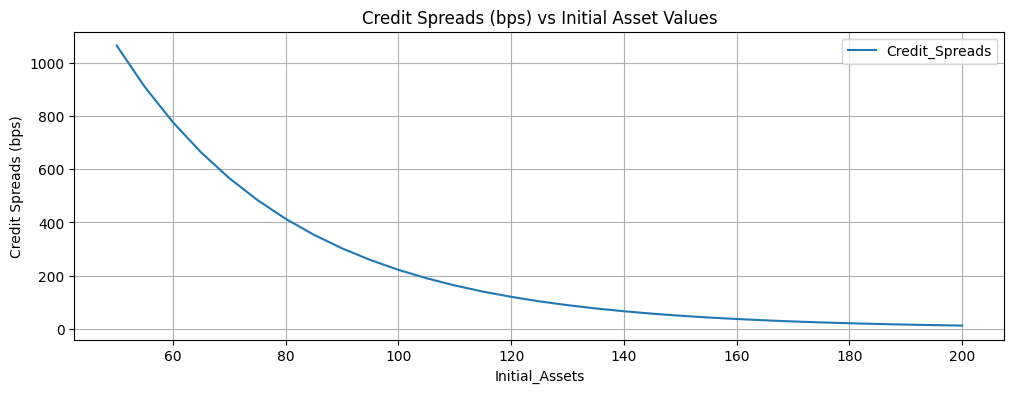

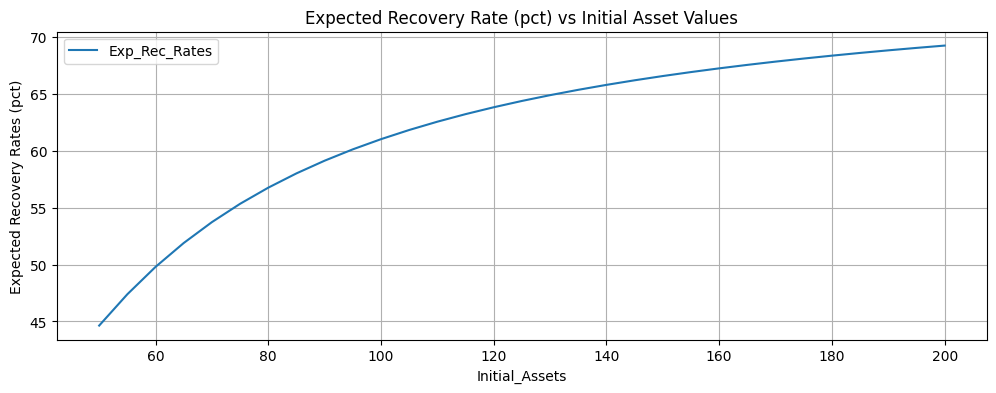

In [8]:
asset_values = [x for x in range(50,205,5)]
credit_spreads = [riskyBondCreditSpread(a,r,sigma_A,T,K) * 1e4 for a in asset_values]
exp_recovery_rates = [expectedRecoveryRate(a,r,sigma_A,T,K) * 1e2 for a in asset_values]


grid_df = pd.DataFrame(data={'Initial_Assets': asset_values, 
                             'Credit_Spreads': credit_spreads,
                             'Exp_Rec_Rates': exp_recovery_rates})  

plt = grid_df.plot(x='Initial_Assets', y='Credit_Spreads', grid=True, title="Credit Spreads (bps) vs Initial Asset Values", figsize=(12,4))
plt.set_ylabel('Credit Spreads (bps)')


plt = grid_df.plot(x='Initial_Assets', y='Exp_Rec_Rates', grid=True, title="Expected Recovery Rate (pct) vs Initial Asset Values", figsize=(12,4))
plt.set_ylabel('Expected Recovery Rates (pct)')


## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

In [9]:
def equityVolatility(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    E0 = fairValueEquity(A,r,sigma_A,T,K)    
    sigma_E = (A / E0) * norm.cdf(d1) * sigma_A
    return sigma_E


In [10]:
equity_vol = equityVolatility(A,r,sigma_A,T,K) * 100

print('Equity Volatility (pct):', round(equity_vol, 2))

Equity Volatility (pct): 46.52


Text(0, 0.5, 'Equity Volatility (pct)')

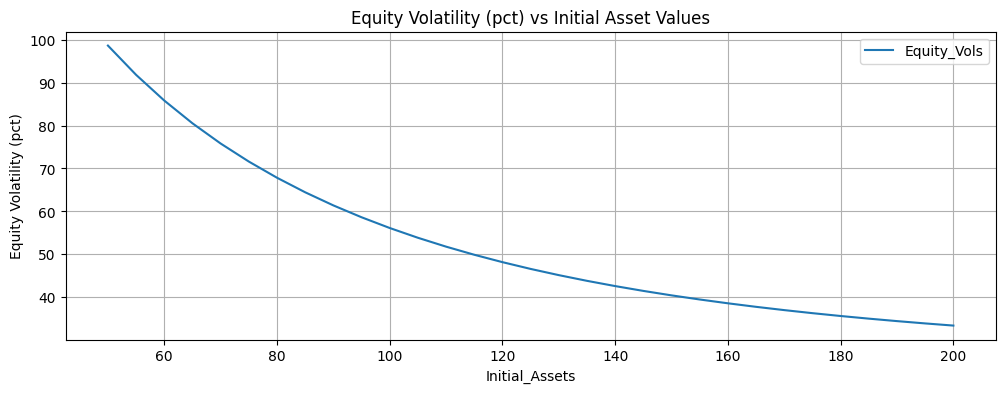

In [11]:
asset_values = [x for x in range(50,205,5)]
equity_volatilities = [equityVolatility(a,r,sigma_A,T,K) * 1e2 for a in asset_values]

grid_df['Equity_Vols'] = equity_volatilities

plt = grid_df.plot(x='Initial_Assets', y='Equity_Vols', grid=True, title="Equity Volatility (pct) vs Initial Asset Values", figsize=(12,4))
plt.set_ylabel('Equity Volatility (pct)')


-----------------------------------------------------------
# Problem 2: LQD ETF basket analysis - bucketed interest rate hedging


## a. Load and explore the LQD basket composition and market data

Load the `lqd_basket_composition` Excel file into a dataframe. It contains the LQD basket constituent face notionals, weights and yields-to-maturities as of 2024-05-03.

Load the `lqd_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for LQD constituents.

How many corporate bonds are in the LQD basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the LQD basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [12]:
# lqd_corp_symbology
lqd_corp_symbology = pd.read_excel('data/lqd_corp_symbology.xlsx')

# Load LQD basket composition file, keep only columns needed for pricing
lqd_basket_composition = pd.read_excel('data/lqd_basket_composition.xlsx')
lqd_basket_composition = lqd_basket_composition[['isin', 'midYield', 'face_notional', 'face_notional_weight']]

# lqd_df
lqd_df = lqd_corp_symbology.merge(lqd_basket_composition, how='inner', on=['isin'])
# print(lqd_df.head())

print('Corporate bonds in LQD basket:', lqd_df.shape[0])

print('Average and median face notionals for bonds in LQD basket:')
print(lqd_df['face_notional'].describe()[['mean', '50%']])

print('Number of unique tickers in LQD basket:', len(lqd_df['ticker'].unique()))

print('Average and median face notionals by ticker:')
lqd_by_ticker = lqd_df[['ticker', 'face_notional']].groupby(['ticker']).sum()
print(lqd_by_ticker['face_notional'].describe()[['mean', '50%']])

print('Mean, median and standard deviation of yields (pct):')
print(lqd_df['midYield'].describe()[['mean', '50%', 'std']])



Corporate bonds in LQD basket: 2813
Average and median face notionals for bonds in LQD basket:
mean    1.144015e+07
50%     9.660000e+06
Name: face_notional, dtype: float64
Number of unique tickers in LQD basket: 408
Average and median face notionals by ticker:
mean    7.887535e+07
50%     3.535350e+07
Name: face_notional, dtype: float64
Mean, median and standard deviation of yields (pct):
mean    5.282206
50%     5.256000
std     0.927345
Name: midYield, dtype: float64


## b. For each bond in the LQD basket, compute the bond DV01 and it's basket DV01 contribution

For each bond
* create the bond object,
* compute the analytic bond DV01 (from yield-to-maturity in the `lqd_basket_composition` dataframe),
* compute the DV01 on basket level (in $USD): basket_DV01 = bond_DV01 * face_notional / 10000

Add following columns to the LQD daframe and display the dataframe head:

| bond_DV01 | basket_DV01 | 
|----------|----------|


In [13]:
# face notionals
bond_face_notionals = lqd_df['face_notional']

# bond objects and dirty prices
lqd_bond_objects = []
lqd_bond_DV01s = []
lqd_basket_DV01s = []


# loop over bonds
for i, df_row in lqd_df.iterrows():
    # bond_object
    bond_object = create_bond_from_symbology(df_row.to_dict())
    
    # bond_dirty_price                
    bond_yield = df_row['midYield'] / 100
    bond_dirty_price = bond_object.dirtyPrice(bond_yield, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)
        
    # Compute duration and DV01
    bond_duration = ql.BondFunctions.duration(bond_object, bond_yield, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)
    bond_DV01 = bond_duration * bond_dirty_price /100 
    basket_DV01 = bond_DV01 * df_row['face_notional'] / 1e4

    # Populate lists
    lqd_bond_objects.append(bond_object)
    lqd_bond_DV01s.append(bond_DV01)
    lqd_basket_DV01s.append(basket_DV01)


# Add bond_DV01 and basket_DV01 to lqd_df
lqd_df['bond_DV01'] = lqd_bond_DV01s
lqd_df['basket_DV01'] = lqd_basket_DV01s

# display(lqd_df.head())
display(lqd_df[['security', 'midYield', 'face_notional', 'bond_DV01', 'basket_DV01']].head())

,security,midYield,face_notional,bond_DV01,basket_DV01
0,A 2.3 03/12/31,4.9935,3559000,4.857520,1728.791247
1,AAPL 4 05/10/28,4.3270,7733000,3.112050,2406.548106
2,AAPL 1.4 08/05/28,4.4125,24482000,3.127953,7657.854875
3,AAPL 3 1/4 08/08/29,4.4140,10484000,4.040795,4236.369387
4,AAPL 2.2 09/11/29,4.4350,15278000,3.995822,6104.816273


## c. Compute the DV01s of the Benchmark US Treasuries

Use the `und_bench_tsy_isin` column in the bond symbology dataframe to find the Benchmark US Treasuries used for bucketed hedging in the LQD portfolio (there should be 7 of them).

Compute the analytic DV01 for each Benchmark US Treasury.


In [14]:
und_bench_tsy_isins = lqd_df['und_bench_tsy_isin'].unique()
print(und_bench_tsy_isins)


# load symbology for 'und_bench_tsy_isins'
bond_symbology = pd.read_excel('data/bond_symbology.xlsx')
bond_symbology  = bond_symbology[bond_symbology['cpn_type'] == 'FIXED']

# Add term and TTM columns
bond_symbology['term'] = (bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / 365.25
bond_symbology['TTM'] = (bond_symbology['maturity'] - as_of_date).dt.days / 365.25

bench_tsy_symbology = bond_symbology.set_index('isin', inplace=False).loc[und_bench_tsy_isins]
bench_tsy_symbology.sort_values('maturity', inplace=True)
# print(bench_tsy_symbology_df)


# market_prices_df
market_prices_df = pd.read_excel('data/bond_market_prices_eod.xlsx')

# bench_tsy_df
bench_tsy_df = bench_tsy_symbology.merge(market_prices_df, how='inner', on=['figi', 'class', 'ticker', 'isin'])
bench_tsy_df['midYield'] = (bench_tsy_df['bidYield'] + bench_tsy_df['askYield']) / 2
print(bench_tsy_df[['figi', 'security', 'midYield']])

# set isin as index
bench_tsy_df.set_index('isin', inplace=True)


['US91282CLW90' 'US91282CMA61' 'US912810UF39' 'US912810UC08'
 'US91282CLZ22' 'US91282CMB45' 'US91282CLY56']
           figi          security  midYield
0  BBG01QZFYJV6  T 4 1/4 11/30/26    4.2470
1  BBG01R4Z7Y32      T 4 12/15/27    4.2225
2  BBG01QZFYD58  T 4 1/8 11/30/29    4.2510
3  BBG01QZFYCF9  T 4 1/8 11/30/31    4.3255
4  BBG01QKHSMP5  T 4 1/4 11/15/34    4.3980
5  BBG01QVTC1Y0  T 4 5/8 11/15/44    4.6820
6  BBG01P1YBJY6  T 4 1/4 08/15/54    4.6105


In [15]:
# compute underlyting US treasury DV01s
tsy_bond_objects = []
tsy_bond_dv01s = []

# loop over bonds
for i, df_row in bench_tsy_df.iterrows():

    # tsy_bond_object
    tsy_bond_object = create_bond_from_symbology(df_row.to_dict())    
    
    # tsy bond yields
    tsy_bond_yield = df_row['midYield'] / 100
    
    # calc tsy_bond_dirty_price, tsy_bond_duration and tsy_bond_dv01
    tsy_bond_dirty_price = tsy_bond_object.dirtyPrice(tsy_bond_yield, tsy_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    tsy_bond_duration = ql.BondFunctions.duration(tsy_bond_object, tsy_bond_yield, tsy_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    tsy_bond_dv01 = tsy_bond_duration * tsy_bond_dirty_price / 100
    
    tsy_bond_objects.append(tsy_bond_object)
    tsy_bond_dv01s.append(tsy_bond_dv01)
    

bench_tsy_df['dv01'] = tsy_bond_dv01s
print(bench_tsy_df[['security', 'midYield', 'dv01']])


                      security  midYield       dv01
isin                                               
US91282CLY56  T 4 1/4 11/30/26    4.2470   1.858627
US91282CMB45      T 4 12/15/27    4.2225   2.777421
US91282CMA61  T 4 1/8 11/30/29    4.2510   4.412634
US91282CLZ22  T 4 1/8 11/30/31    4.3255   5.910960
US91282CLW90  T 4 1/4 11/15/34    4.3980   7.910684
US912810UF39  T 4 5/8 11/15/44    4.6820  12.799133
US912810UC08  T 4 1/4 08/15/54    4.6105  15.409614


## d. Compute the bucketed interest rate DV01s and hedging notionals in terms of Benchmark US Treasuries.

For each bond:
1. Identify the Benchmark US Treasury (via the `security` column) which will be used to hedge the interest rate exposure of the corporate bond.
2. Compute the IR hedge notional in the Benchmark US Treasury, using the ratio of corporate bond DV01 over Benchmark Treasury DV01.
3. Compute the IR hedge notional on basket level (in $USD)

Extend the LQD combined dataframe with the following columns:


| und_bench_tsy_security | und_bench_tsy_DV01 | und_bench_tsy_hedge_ratio | basket_hedge_notional |
|----------|-------------|-------|-------------|

where

- und_bench_tsy_security = Underlying Benchmark US Treasury `security` name
- und_bench_tsy_DV01 = Underlying Benchmark US Treasury DV01
- und_bench_tsy_hedge_ratio = bond_DV01 / und_bench_tsy_DV01
- basket_hedge_notional = face_notional * und_bench_tsy_hedge_ratio


In [16]:
bench_tsy_securities = []
und_bench_tsy_dv01s = []
und_bench_tsy_hedge_ratios = []
basket_hedge_notionals = []

# loop over LQD bonds
for i, df_row in lqd_df.iterrows():
    # corp_bond_object
    corp_bond_object = lqd_bond_objects[i]
    
    # bench_tsy_security
    corp_bond_yield = df_row['midYield'] / 100
    corp_bond_dv01 = df_row['bond_DV01'] / 100
    bench_tsy_isin = df_row['und_bench_tsy_isin']

    bench_tsy_df_row = bench_tsy_df.loc[bench_tsy_isin]
    bench_tsy_security = bench_tsy_df_row['security']
    
    # und_bench_tsy_dv01 and und_bench_tsy_hedge_notional
    und_bench_tsy_dv01 = bench_tsy_df_row['dv01']
    und_bench_tsy_hedge_notional = corp_bond_dv01 / und_bench_tsy_dv01 * 100
        
    bench_tsy_securities.append(bench_tsy_security)
    und_bench_tsy_dv01s.append(und_bench_tsy_dv01)
    und_bench_tsy_hedge_ratios.append(und_bench_tsy_hedge_notional)

lqd_df['bench_tsy_security'] = bench_tsy_securities
lqd_df['und_bench_tsy_dv01'] = und_bench_tsy_dv01s
lqd_df['und_bench_tsy_hedge_ratio'] = und_bench_tsy_hedge_ratios
lqd_df['basket_hedge_notional'] = round(und_bench_tsy_hedge_ratios * lqd_df['face_notional'], 0)

display(lqd_df[['security', 'bench_tsy_security', 'bond_DV01', 'und_bench_tsy_dv01', 'und_bench_tsy_hedge_ratio', 'face_notional', 'basket_hedge_notional']].head())

,security,bench_tsy_security,bond_DV01,und_bench_tsy_dv01,und_bench_tsy_hedge_ratio,face_notional,basket_hedge_notional
0,A 2.3 03/12/31,T 4 1/4 11/15/34,4.857520,7.910684,0.614045,3559000,2185388.0
1,AAPL 4 05/10/28,T 4 1/8 11/30/29,3.112050,4.412634,0.705259,7733000,5453767.0
2,AAPL 1.4 08/05/28,T 4 1/8 11/30/29,3.127953,4.412634,0.708863,24482000,17354383.0
3,AAPL 3 1/4 08/08/29,T 4 1/8 11/30/29,4.040795,4.412634,0.915733,10484000,9600545.0
4,AAPL 2.2 09/11/29,T 4 1/8 11/30/29,3.995822,4.412634,0.905541,15278000,13834856.0


## e. Aggregate the LQD basket metrics by underlying benchmark US Treasury buckets

Aggregate the following LQD basket metrics by underlying Benchmark US Treasury (7 buckets):

* bond counts,
* face notional,
* basket DV01 risk 
* basket hedge notional
 

by the 7 Benchmark US Treasury buckets (use groupby `und_bench_tsy_isin`).

Display the aggregated LQD basket dataframe.


In [17]:
lqd_df['basket_count'] = 1
lqd_bucketed_dv01s = lqd_df[['und_bench_tsy_isin', 'basket_count', 'face_notional', 'basket_DV01', 'basket_hedge_notional']].groupby(['und_bench_tsy_isin']).sum()

# lqd_bucketed_dv01s.loc['Total']= lqd_bucketed_dv01s.sum()
display(lqd_bucketed_dv01s)


,basket_count,face_notional,basket_DV01,basket_hedge_notional
und_bench_tsy_isin,,,,
US912810UC08,654,7750697000,9.383819e+06,6.089588e+09
US912810UF39,422,4912744000,5.201950e+06,4.064299e+09
US91282CLW90,855,9531508000,6.642264e+06,8.396573e+09
US91282CLY56,3,41848000,1.651557e+04,8.885897e+07
US91282CLZ22,60,525612000,2.938617e+05,4.971472e+08
US91282CMA61,816,9369893000,3.852420e+06,8.730432e+09
US91282CMB45,3,48842000,1.721300e+04,6.197476e+07


## f. Display and plot the aggregated LQD basket dataframe

Merge the underlying benchmark treasury symbology and sort by benchmark treasury TTM to obtain the combined dataframe below:

| isin | security | TTM | basket_count | face_notional | basket_DV01 | basket_hedge_notional |
|----------|----------|----------|----------|----------|----------|----------|


Display the combined dataframe. Which US Treasury bucket contains the highest DV01 risk?

Create bar plots (using 'security' as x-axis) for following metrics:
* basket_count,
* basket_DV01 and
* face_notional + basket_hedge_notional.

In [18]:
# Merge underlying treasury 'security'and 'TTM' from bond symbology 
lqd_bucketed_dv01s_combined = lqd_bucketed_dv01s.merge(bond_symbology[['isin', 'security', 'TTM']], left_on='und_bench_tsy_isin', right_on='isin')

lqd_bucketed_dv01s_combined  = lqd_bucketed_dv01s_combined[['isin', 'security', 'TTM', 'basket_count', 'face_notional', 'basket_DV01', 'basket_hedge_notional']]
lqd_bucketed_dv01s_combined.sort_values('TTM', inplace=True)

display(lqd_bucketed_dv01s_combined)

,isin,security,TTM,basket_count,face_notional,basket_DV01,basket_hedge_notional
3,US91282CLY56,T 4 1/4 11/30/26,1.963039,3,41848000,1.651557e+04,8.885897e+07
6,US91282CMB45,T 4 12/15/27,3.003422,3,48842000,1.721300e+04,6.197476e+07
5,US91282CMA61,T 4 1/8 11/30/29,4.963723,816,9369893000,3.852420e+06,8.730432e+09
4,US91282CLZ22,T 4 1/8 11/30/31,6.962355,60,525612000,2.938617e+05,4.971472e+08
2,US91282CLW90,T 4 1/4 11/15/34,9.921971,855,9531508000,6.642264e+06,8.396573e+09
1,US912810UF39,T 4 5/8 11/15/44,19.923340,422,4912744000,5.201950e+06,4.064299e+09
0,US912810UC08,T 4 1/4 08/15/54,29.670089,654,7750697000,9.383819e+06,6.089588e+09


The 30 years US Treasury bucket contains the highest DV01 risk!

<Axes: title={'center': 'Bucketed IR hedge notionals for LQD basket (by benchmark US treasuries)'}, xlabel='security'>

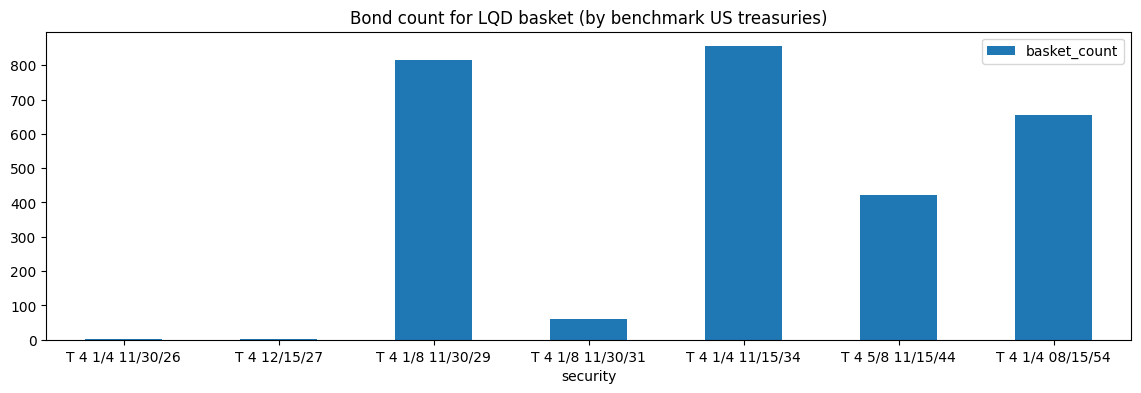

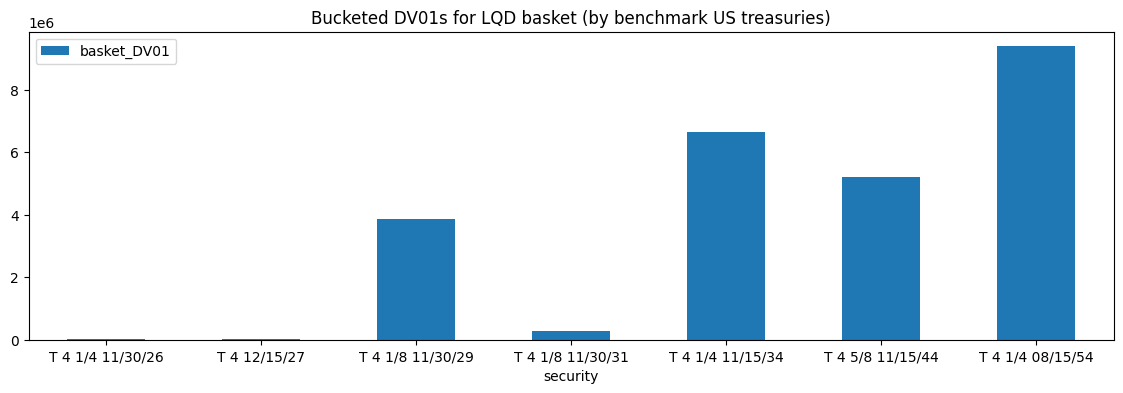

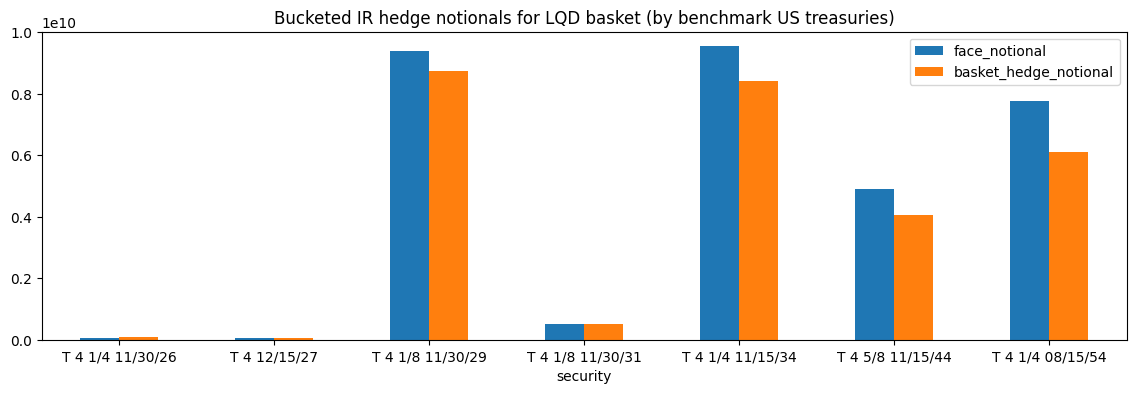

In [19]:
# Create bar plots (using 'security' as x-axis) for metrics

# Bar chart for basket_count
lqd_bucketed_dv01s_combined.plot.bar(x='security', y=['basket_count'], rot=0, figsize=(14,4), title='Bond count for LQD basket (by benchmark US treasuries)')

# Bar chart for basket_DV01
lqd_bucketed_dv01s_combined.plot.bar(x='security', y=['basket_DV01'], rot=0, figsize=(14,4), title='Bucketed DV01s for LQD basket (by benchmark US treasuries)')

# Bar chart for basket_DV01
lqd_bucketed_dv01s_combined.plot.bar(x='security', y=['face_notional', 'basket_hedge_notional'], rot=0, figsize=(14,4), title='Bucketed IR hedge notionals for LQD basket (by benchmark US treasuries)')


# Problem 3: CDS Intrinisc Index analysis on CDX IG 5Y


## a. Load and explore the CDX IG 5Y symbology, basket composition and market data

Load the `cdx_symbology` Excel file into a dataframe. Identify .

Load the CDX IG 5Y Series 43 indexd the `cdx_basket_composition` Excel file into a dataframe. It contains the CDX IG 5Y Series 43 basket composition and CDS Par Spread quotes as of 2024-12-13.

How many CDS contracts are in the CDX index basket? What are the contractual specs and weights of each CDS? Remember that each CDS is identical to the CDX index and the basket has uniform weights.

Compute mean, median and standard deviation of CDS Par Spreads in the basket.

Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.

In [20]:
cdx_symbology_df = pd.read_excel('data/cdx_symbology.xlsx')
cdx_symbology_df.set_index('symbol', inplace=True)


# Identfy the CDX IG 5Y Series 43 index
cdx_IG_43_5Y_symbology_df = cdx_symbology_df.loc['CDX_CDXIG543']
print(cdx_IG_43_5Y_symbology_df.T)  

ticker                        CDXIG543
class                           Curncy
security                 MARKIT CDX IG
name         MARKIT CDX.NA.IG.43 12/29
type               CREDIT DEFAULT SWAP
dcc                            ACT/360
cpn_first          2024-12-20 00:00:00
maturity           2029-12-20 00:00:00
currency                           USD
Name: CDX_CDXIG543, dtype: object


Number of CDS contracts in the basket: 125
CDS specs and weights: coupon = 100 bps, maturity = 2029-12-20, dcc = ACT/360, weights (pct) = 0.8
Mean, median and standard deviation of CDS Par Spreads in the basket:
mean    50.706338
50%     42.142500
std     26.024877
Name: cds_par_spread_5y, dtype: float64


Text(0.5, 0, 'Ticker')

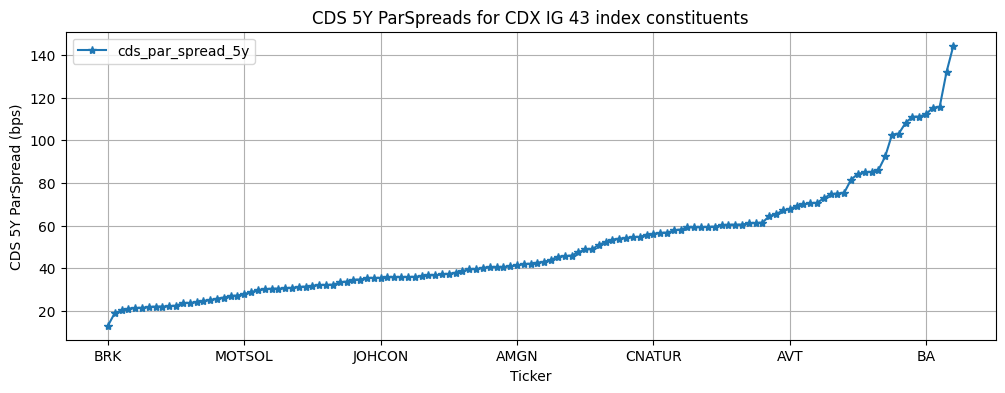

In [21]:
# cdx_basket_df
cdx_basket_df = pd.read_excel('data/cdx_ig_43_5y_basket_composition.xlsx')

print('Number of CDS contracts in the basket:', cdx_basket_df.shape[0])

# CDS IG contracts specs are identical to the CDX IG ones, printed above
cds_basket_weight = 1 / cdx_basket_df.shape[0]
print('CDS specs and weights: coupon = 100 bps, maturity = 2029-12-20, dcc = ACT/360, weights (pct) =', cds_basket_weight * 100)

# Compute mean, median and standard deviation of CDS Par Spreads in the basket.
print('Mean, median and standard deviation of CDS Par Spreads in the basket:')
print(cdx_basket_df['cds_par_spread_5y'].describe()[['mean', '50%', 'std']])

# Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.
cdx_basket_df.sort_values('cds_par_spread_5y', inplace=True)
plt = cdx_basket_df.plot(x='ticker', y='cds_par_spread_5y', grid=True, style='*-', title='CDS 5Y ParSpreads for CDX IG 43 index constituents', figsize=(12,4))
plt.set_ylabel('CDS 5Y ParSpread (bps)')
plt.set_xlabel('Ticker')


## b. Calibrate the US SOFR yield curve (via bootstrapping)
Load the `sofr_swap_symbology` Excel file into a dataframe.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe.

Follow Homework 4, Problem 2 and calibrate the SOFR discount curve as of 2024-12-13.

In [22]:
# sofr_symbology
sofr_symbology = pd.read_excel('data/sofr_swaps_symbology.xlsx')
# sofr_market_quotes
sofr_market_quotes = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx')

# sofr_combined
sofr_combined = sofr_symbology.merge(sofr_market_quotes[sofr_market_quotes['date'] == '2024-12-13'], how='left', on=['figi'])
display(sofr_combined)

# calibrate SOFR discount curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_combined, 'midRate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status,date,bidRate,askRate,midRate
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,4.1858,4.1958,4.19080
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,4.0524,4.0585,4.05545
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9883,3.9944,3.99135
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9133,3.9181,3.91570
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.8937,3.8991,3.89640
5,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9015,3.9065,3.90400
6,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9246,3.9304,3.92750
7,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.7602,3.7662,3.76320


## c. Compute the intrinsic Premium Leg PV of the CDX index basket

Follow Homework 4, Problem 3. 

For each instrument in the basket, create the CDS object. 

Use the calibrated SOFR discount curve and the CDS Par Spreads to calibrate the individual hazard rate / survival probability curves.

Compute the Premium Leg PV for each CDS and aggregate the intrinsic Premium Leg PV of the basket (using basket weights).

Plot the Premium Leg PVs for individual CDS constituents.

In [23]:
# Common CDS specs, matching CDX IG 5Y contract
side = ql.Protection.Seller
cds_recovery_rate = 0.4
cds_face_notional = 100
contractual_spread_bps = 100

cds_start_date = calc_date
cds_maturity_date = ql.Date(20, 12, 2029)

# Create common CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create common CDS object
cds_object = ql.CreditDefaultSwap(side, cds_face_notional, contractual_spread_bps / 10000, cds_schedule, ql.Following, ql.Actual360())


In [24]:
# cds_par_spread_columns
cds_par_spread_columns = [f'cds_par_spread_{y}y' for y in [1, 2, 3, 5, 7, 10]]


# Compute and aggregate CDS Premium and Default Legs for index constituents
cds_premium_leg_pvs = []
cds_default_leg_pvs = []
cds_pvs = []

cdx_ig_5y_premium_leg_pv = 0
cdx_ig_5y_default_leg_pv = 0
cdx_ig_5y_pv = 0

for i, row in cdx_basket_df.iterrows():

    # cds_par_spreads_bps
    cds_par_spreads_bps = list(row[cds_par_spread_columns])

    # calibrate_cds_hazard_rate_curve
    hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_bps, cds_recovery_rate)

    # Create CDS pricing engine
    default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
    cds_pricing_engine = ql.MidPointCdsEngine(default_prob_curve_handle, cds_recovery_rate, sofr_yield_curve_handle)

    # setPricingEngine
    cds_object.setPricingEngine(cds_pricing_engine)
    
    # Calc individual CDS PVs
    cds_premium_leg_pv = cds_object.couponLegNPV()
    cds_default_leg_pv = -cds_object.defaultLegNPV()
    cds_pv = cds_object.NPV()
    
    # Aggregate CDX IG 5Y basket PVs
    cdx_ig_5y_premium_leg_pv += cds_premium_leg_pv * cds_basket_weight
    cdx_ig_5y_default_leg_pv += cds_default_leg_pv * cds_basket_weight
    cdx_ig_5y_pv += cds_pv * cds_basket_weight

    cds_premium_leg_pvs.append(cds_premium_leg_pv)
    cds_default_leg_pvs.append(cds_default_leg_pv)
    cds_pvs.append(cds_pv)


# Add results to cdx dataframe
cdx_basket_df['premium_leg_pv'] = cds_premium_leg_pvs
cdx_basket_df['default_leg_pv'] = cds_default_leg_pvs
cdx_basket_df['cds_pv'] = cds_pvs

# Print CDX IG 5Y aggregated NAV results
print('cdx_ig_5Y_premium_leg_pv:', round(cdx_ig_5y_premium_leg_pv, 2))


cdx_ig_5Y_premium_leg_pv: 4.53


Text(0.5, 0, 'Ticker')

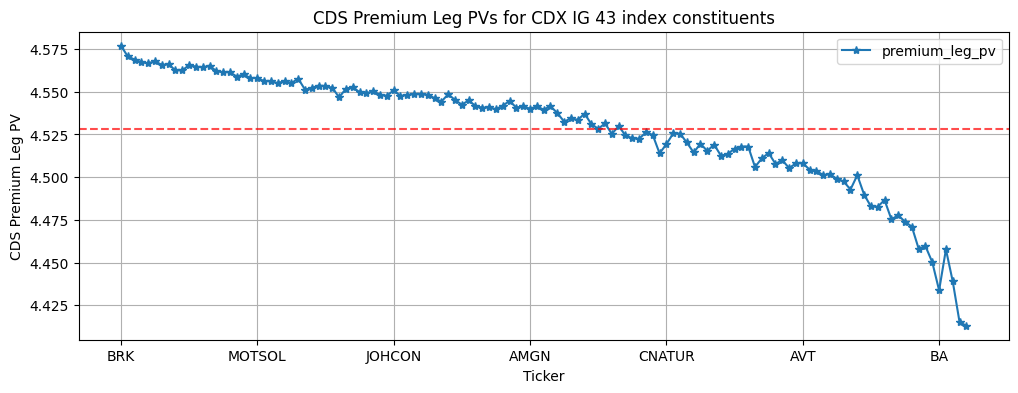

In [25]:
# Plot Premium Leg PVs for individual CDS constituents
plt = cdx_basket_df.plot(x='ticker', y='premium_leg_pv', grid=True, style='*-', title='CDS Premium Leg PVs for CDX IG 43 index constituents', figsize=(12,4))
plt.axhline(cdx_ig_5y_premium_leg_pv, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('CDS Premium Leg PV')
plt.set_xlabel('Ticker')


## d. Compute the intrinsic Default Leg PV of the CDX index basket

Compute the Default Leg PV for each CDS and determine the intrinsic Default Leg PV of the basket (using basket weights).

Plot the Default Leg PVs for individual CDS constituents.

In [26]:
# Print CDX IG 5Y aggregated NAV results
print('cdx_ig_5Y_default_leg_pv:', round(cdx_ig_5y_default_leg_pv, 2))

cdx_ig_5Y_default_leg_pv: 2.28


Text(0.5, 0, 'Ticker')

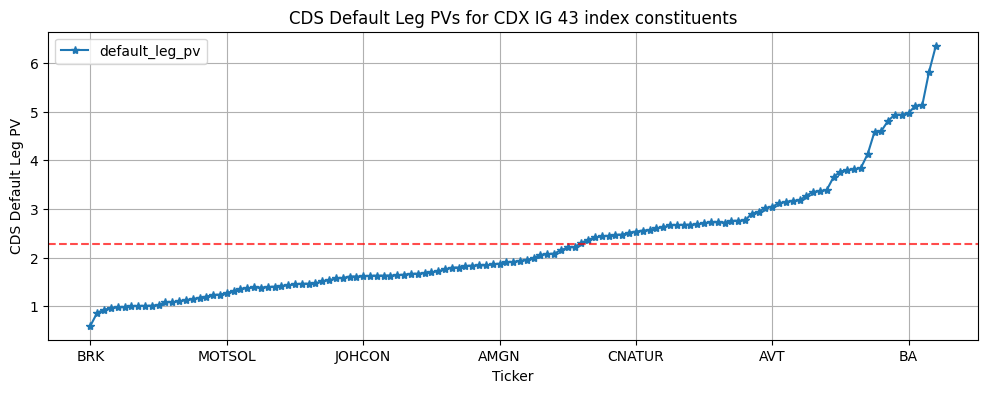

In [27]:
# Plot Default Leg PVs for individual CDS constituents
plt = cdx_basket_df.plot(x='ticker', y='default_leg_pv', grid=True, style='*-', title='CDS Default Leg PVs for CDX IG 43 index constituents', figsize=(12,4))
plt.axhline(cdx_ig_5y_default_leg_pv, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('CDS Default Leg PV')
plt.set_xlabel('Ticker')


## e. Compute the intrinsic PV and Par Spread of the CDX index basket

Compute the intrinsic index PV. 

Compute the CDX instrinsic index Par Spread (using ratio of CDX default vs premium legs).

For comparison, plot the CDS PVs for individual CDS constituents.

In [28]:
# Compute CDX IG 5Y Par Spread
cdx_ig_5y_par_spread_bps = contractual_spread_bps * cdx_ig_5y_default_leg_pv / cdx_ig_5y_premium_leg_pv

# Print CDX IG 5Y aggregated NAV results
print('cdx_ig_5Y_pv:', round(cdx_ig_5y_pv, 2))
print('cdx_ig_5y_par_spread:', round(cdx_ig_5y_par_spread_bps, 2))


cdx_ig_5Y_pv: 2.24
cdx_ig_5y_par_spread: 50.43


Text(0.5, 0, 'Ticker')

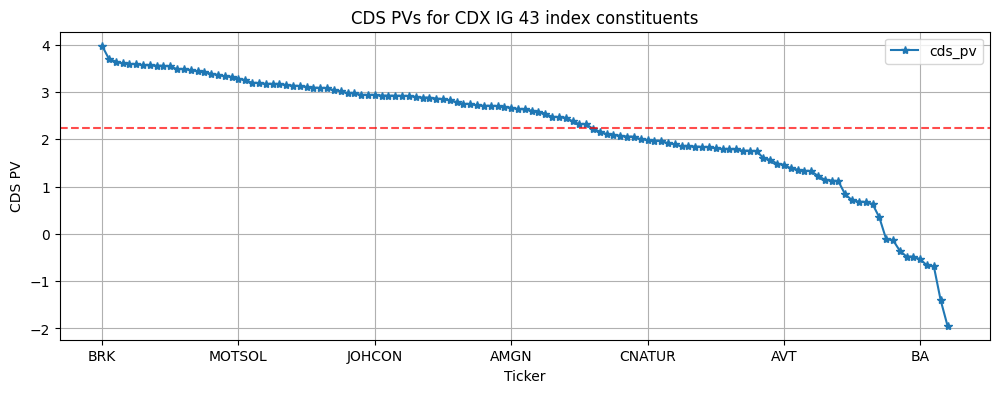

In [29]:
# Plot CDS PVs for individual CDS constituents
plt = cdx_basket_df.plot(x='ticker', y='cds_pv', grid=True, style='*-', title='CDS PVs for CDX IG 43 index constituents', figsize=(12,4))
plt.axhline(cdx_ig_5y_pv, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('CDS PV')
plt.set_xlabel('Ticker')


-----------------------------------------------------------
# Problem 4: PCA curve shape analysis of historical US SOFR OIS rates


## a. Load and explore US SOFR swaps extended symbology and market data

Load the `sofr_swap_symbology_ext` Excel file into a dataframe. List all available swap tenors.

Load the `sofr_swaps_market_data_eod_ext` Excel file into a dataframe. 

Plot the historial time series of SOFR rates for the available tenors.

,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
figi,,,,,,,,,,,
BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK33,USOSFR4,Curncy,USOSFR4 Curncy,USD OIS ANN VS SOFR 4Y,4,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK60,USOSFR6,Curncy,USOSFR6 Curncy,USD OIS ANN VS SOFR 6Y,6,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK88,USOSFR8,Curncy,USOSFR8 Curncy,USD OIS ANN VS SOFR 8Y,8,SWAP,ACT/360,NONE,US,USD,ACTV
BBG00KFWPK97,USOSFR9,Curncy,USOSFR9 Curncy,USD OIS ANN VS SOFR 9Y,9,SWAP,ACT/360,NONE,US,USD,ACTV


tenor           1        2        3       4       5        6        7   \
date                                                                     
2024-12-09  4.1363  3.93625  3.84005  3.7780  3.7409  3.72285  3.71365   
2024-12-10  4.1475  3.95675  3.86235  3.8002  3.7620  3.74310  3.73340   
2024-12-11  4.1420  3.97035  3.88975  3.8345  3.8013  3.78470  3.77685   
2024-12-12  4.1577  4.00475  3.93275  3.8814  3.8510  3.83680  3.83065   
2024-12-13  4.1908  4.05545  3.99135  3.9440  3.9157  3.90250  3.89640   

tenor            8        9        10       12       15       20       25  \
date                                                                        
2024-12-09  3.71060  3.71280  3.71840  3.73675  3.75925  3.74505  3.66930   
2024-12-10  3.72970  3.73100  3.73615  3.75520  3.77800  3.76515  3.69100   
2024-12-11  3.77430  3.77675  3.78250  3.80335  3.82820  3.81795  3.74595   
2024-12-12  3.82970  3.83320  3.84000  3.86055  3.88575  3.87590  3.80465   
2024-12-13  3.89495

Text(0.5, 0, 'Date')

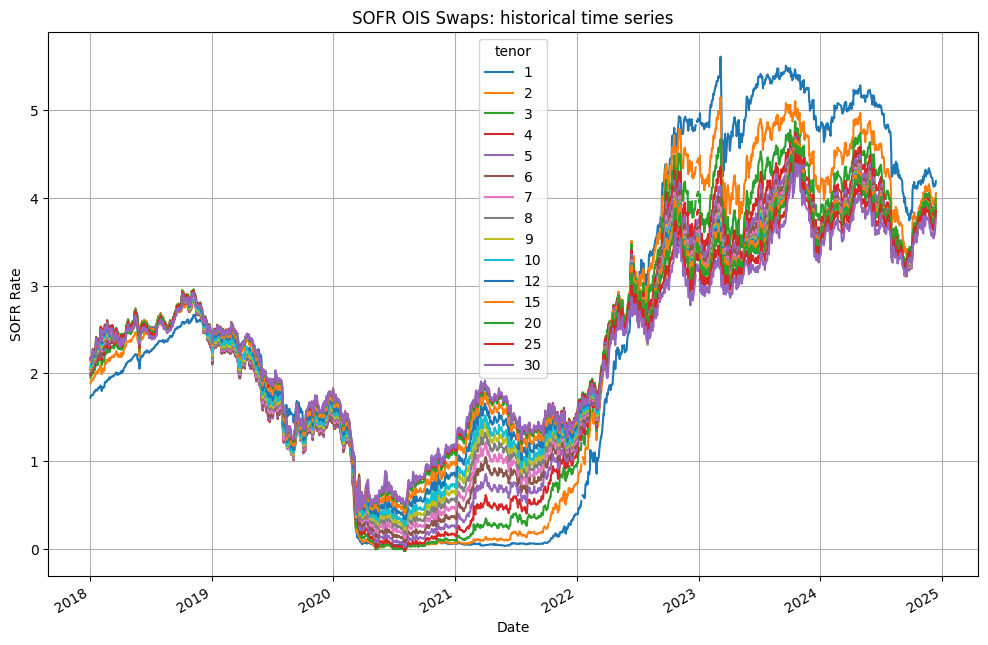

In [30]:
# sofr_symbology
sofr_symbology = pd.read_excel('data/sofr_swaps_symbology_ext.xlsx')
sofr_symbology.set_index('figi',inplace=True)
display(sofr_symbology)

# sofr_market_quotes
sofr_market_quotes = pd.read_excel('data/sofr_swaps_market_data_eod_ext.xlsx')

# pivot to get SOFR rates time series
sofr_quotes_ts = sofr_market_quotes.pivot(index="date", columns="figi", values="midRate")
sofr_quotes_ts.columns = sofr_symbology.tenor[sofr_quotes_ts.columns]
print(sofr_quotes_ts.tail())

plt = sofr_quotes_ts.plot(grid=True, style='-', title='SOFR OIS Swaps: historical time series', figsize=(12,8))
plt.set_ylabel('SOFR Rate')
plt.set_xlabel('Date')

## b. Run PCA analysis of SOFR OIS rate curves in level space

Run PCA analysis of SOFR OIS rates.

Display and plot the (factor loadings of the) first 3 principal components.

Extract the explained variance ratios for the first 5 principal components and add the cumulative explained variance ratio. Plot the results using a bar plot.

How much explanatory power is captured in the first 3 principal components?

Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

You can use PCA from sklearn.decomposition, or any other equivalent package.

tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
PC1,0.371016,0.332628,0.303771,0.283568,0.268761,0.257232,0.247952,0.240514,0.234650,0.229889,0.223110,0.216584,0.206802,0.196566,0.187853
PC2,0.635079,0.371274,0.184266,0.061453,-0.022327,-0.079384,-0.124456,-0.153627,-0.174862,-0.191014,-0.213344,-0.230978,-0.248536,-0.265759,-0.277275
PC3,0.567439,-0.137417,-0.334746,-0.340502,-0.285617,-0.209945,-0.146365,-0.081282,-0.026189,0.015838,0.089922,0.169894,0.245974,0.286106,0.311774


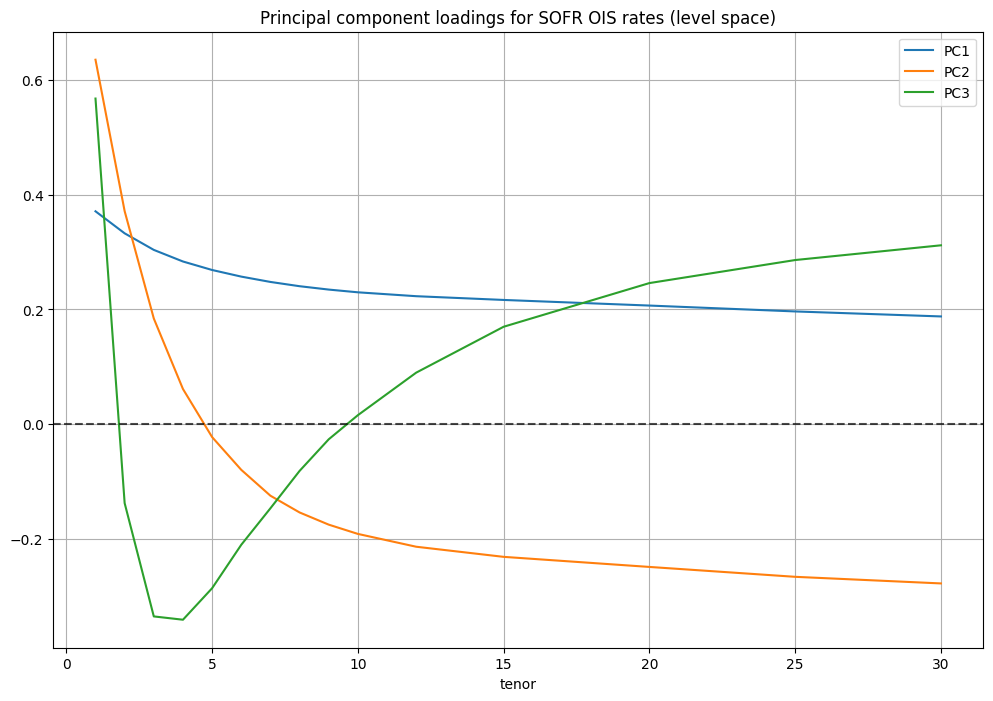

In [31]:
from sklearn.decomposition import PCA

data = sofr_quotes_ts.dropna()
# data = sofr_quotes_ts.diff().dropna()

# Perform PCA
pca = PCA()
pca.fit(data)

# Keep top 3 principal components
components = pca.components_[0:3, :]  # Eigenvectors (loadings)
components_df = pd.DataFrame(components).T
components_df.columns = ['PC1', 'PC2', 'PC3']
components_df.index = data.columns

display(components_df.T)

# Plot components_df
plt = components_df.plot(grid=True, style='-', title='Principal component loadings for SOFR OIS rates (level space)', figsize=(12,8))
plt.axhline(0, color='black', linestyle='--', alpha=0.7)

,PC1,PC2,PC3,PC4,PC5
PCA_Explained_Variance,98.449011,1.254799,0.275708,0.011540,0.007248
PCA_Cumulative_Variance,98.449011,99.703810,99.979518,99.991058,99.998305


Explanatory power captured in the first 3 principal components:  99.9795


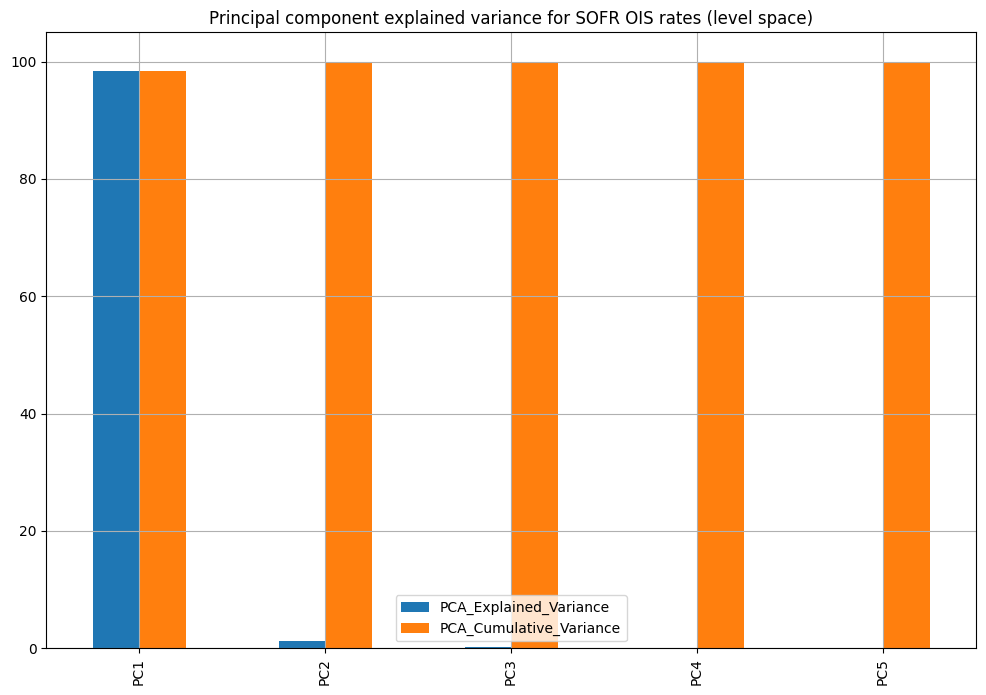

In [32]:
# Explained_variance
explained_variance = pca.explained_variance_ratio_[0:5]  # Variance per PC
explained_variance_df = pd.DataFrame(explained_variance * 100)
explained_variance_df.columns = ['PCA_Explained_Variance']
explained_variance_df.index = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
explained_variance_df['PCA_Cumulative_Variance'] = explained_variance_df['PCA_Explained_Variance'].cumsum()
display(explained_variance_df.T)

# Plot explained_variance_df
explained_variance_df.plot.bar(grid=True, style='-', title='Principal component explained variance for SOFR OIS rates (level space)', figsize=(12,8))

# How much explanatory power is captured in the first 3 principal components?
print('Explanatory power captured in the first 3 principal components: ', round(explained_variance_df['PCA_Cumulative_Variance']['PC3'], 4))

<Axes: title={'center': 'Principal component scores for SOFR OIS rates (level space)'}, xlabel='date'>

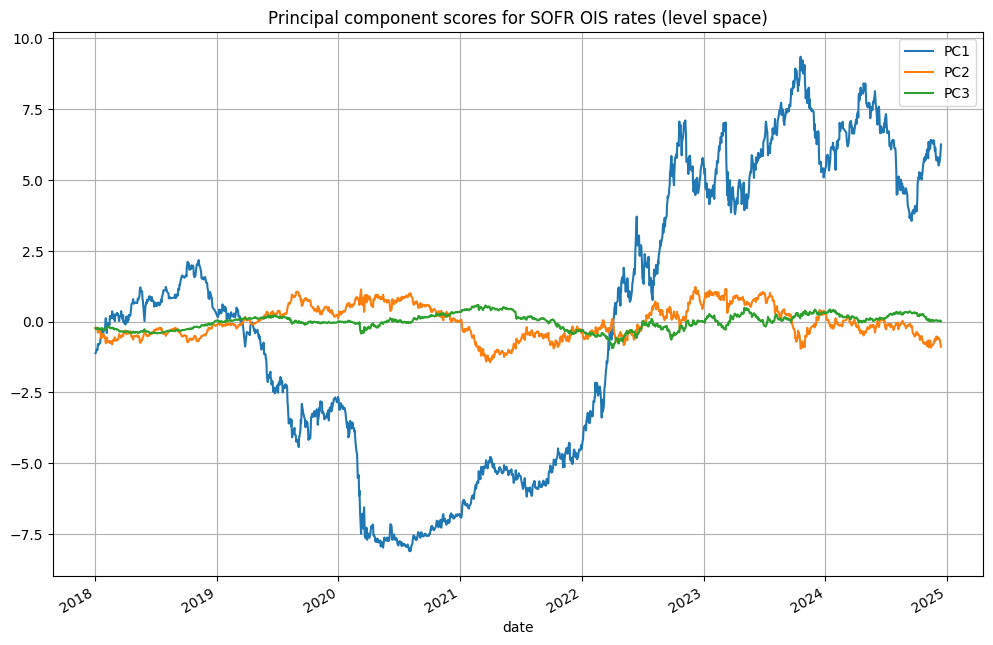

In [33]:
# Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

# Compute scores for top 3 principal components
scores = pca.fit_transform(data)[:, 0:3]

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)
scores_df.index=data.index
scores_df.columns=['PC1', 'PC2', 'PC3']

# Plot scores
scores_df.plot(grid=True, style='-', title='Principal component scores for SOFR OIS rates (level space)', figsize=(12,8))



## c. Run PCA analysis of SOFR OIS rate curves in (daily) differences space

Repeat the PCA analysis from b. in daily difference space.


tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
PC1,0.183469,0.249237,0.269004,0.276925,0.281253,0.281444,0.280769,0.276195,0.275582,0.272013,0.260832,0.250075,0.241473,0.229842,0.223823
PC2,0.460863,0.457873,0.339644,0.222909,0.122871,0.046933,-0.011750,-0.056493,-0.103649,-0.136440,-0.179902,-0.230952,-0.273738,-0.309304,-0.326523
PC3,0.619206,0.225819,-0.095001,-0.240549,-0.277852,-0.244628,-0.209852,-0.174620,-0.110316,-0.076696,0.010859,0.107881,0.203436,0.310847,0.345406


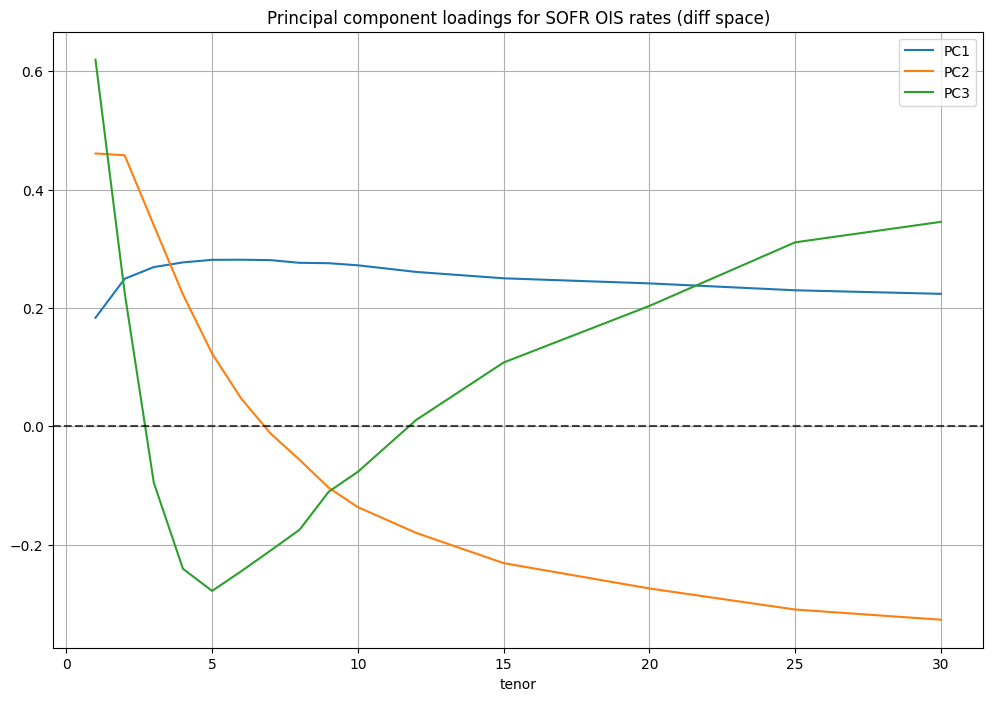

In [34]:
from sklearn.decomposition import PCA

# data = sofr_quotes_ts.dropna()
data = sofr_quotes_ts.diff().dropna()

# Perform PCA
pca = PCA()
pca.fit(data)

# Keep top 3 principal components
components = pca.components_[0:3, :]  # Eigenvectors (loadings)
components_df = pd.DataFrame(components).T
components_df.columns = ['PC1', 'PC2', 'PC3']
components_df.index = data.columns

display(components_df.T)

# Plot components_df
plt = components_df.plot(grid=True, style='-', title='Principal component loadings for SOFR OIS rates (diff space)', figsize=(12,8))
plt.axhline(0, color='black', linestyle='--', alpha=0.7)


,PC1,PC2,PC3,PC4,PC5
PCA_Explained_Variance,88.312699,9.127354,1.468444,0.313791,0.249727
PCA_Cumulative_Variance,88.312699,97.440053,98.908497,99.222288,99.472016


Explanatory power captured in the first 3 principal components:  98.9085


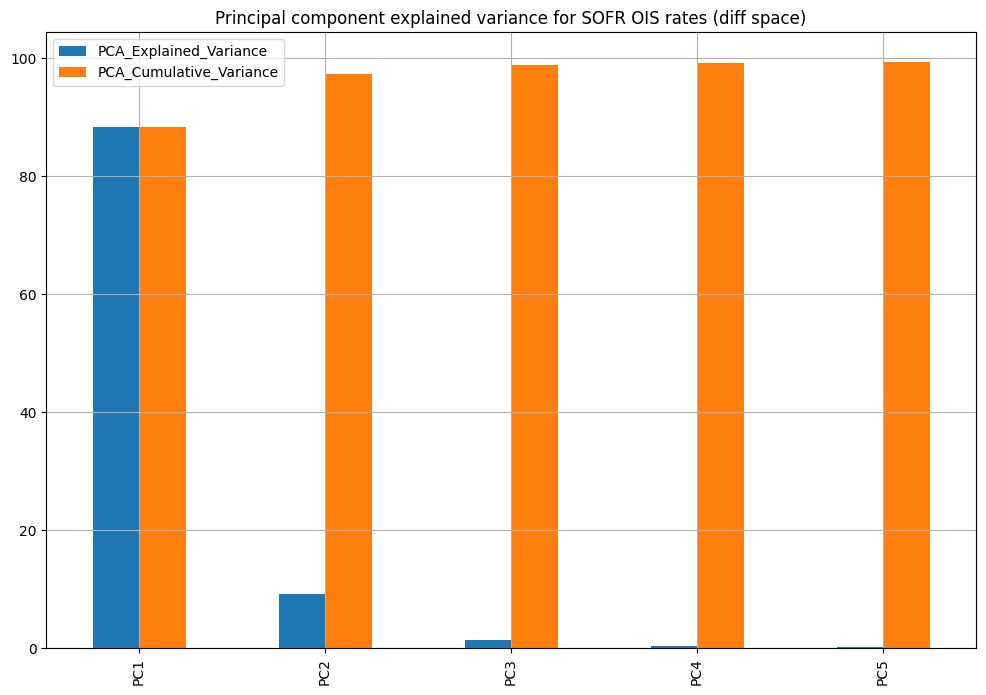

In [35]:
# Explained_variance
explained_variance = pca.explained_variance_ratio_[0:5]  # Variance per PC
explained_variance_df = pd.DataFrame(explained_variance * 100)
explained_variance_df.columns = ['PCA_Explained_Variance']
explained_variance_df.index = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
explained_variance_df['PCA_Cumulative_Variance'] = explained_variance_df['PCA_Explained_Variance'].cumsum()
display(explained_variance_df.T)

# Plot explained_variance_df
explained_variance_df.plot.bar(grid=True, style='-', title='Principal component explained variance for SOFR OIS rates (diff space)', figsize=(12,8))

# How much explanatory power is captured in the first 3 principal components?
print('Explanatory power captured in the first 3 principal components: ', round(explained_variance_df['PCA_Cumulative_Variance']['PC3'], 4))

<Axes: title={'center': 'Principal component cumulative scores for SOFR OIS rates (converted to level space)'}, xlabel='date'>

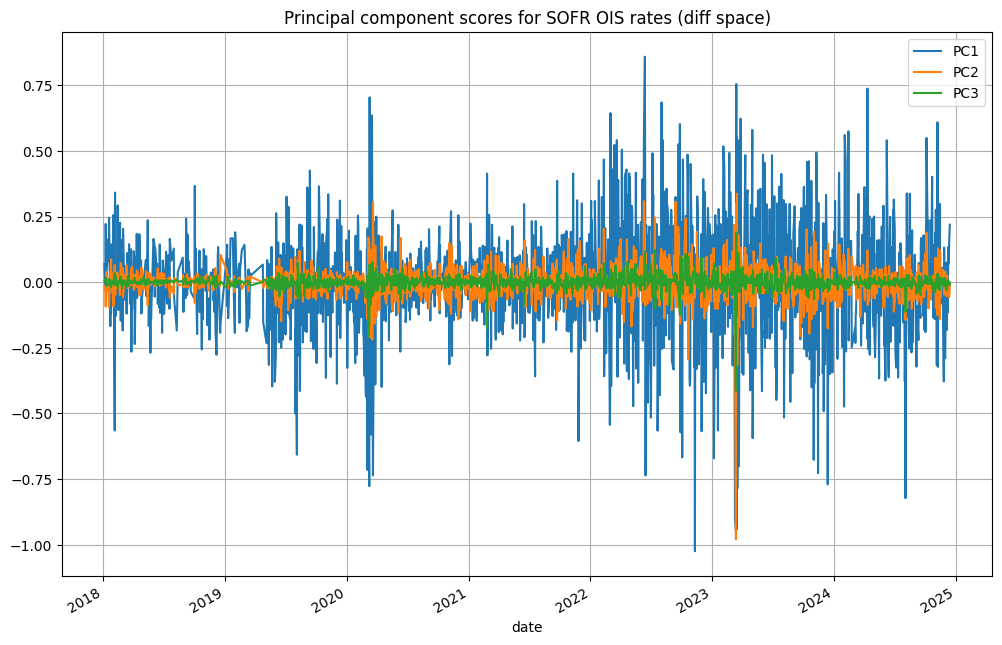

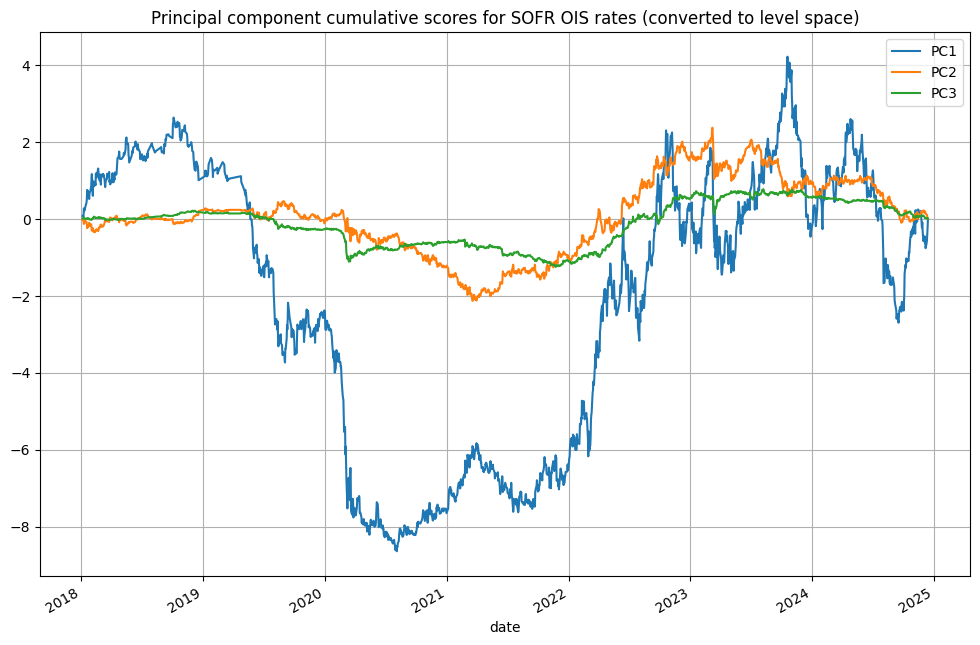

In [36]:
# Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

# Compute scores for top 3 principal components
scores = pca.fit_transform(data)[:, 0:3]

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)
scores_df.index=data.index
scores_df.columns=['PC1', 'PC2', 'PC3']

# Plot scores
scores_df.plot(grid=True, style='-', title='Principal component scores for SOFR OIS rates (diff space)', figsize=(12,8))


# Aggregate scores to obtain cumulative returns
agg_scores_df = scores_df.cumsum()

# Plot aggregated (cumulative returns) scores
agg_scores_df.plot(grid=True, style='-', title='Principal component cumulative scores for SOFR OIS rates (converted to level space)', figsize=(12,8))

# Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

## d. Intuitive interpretation of PC1, PC2 and PC3 and connection to the Nelson-Siegel model

Identify and interpret the curve shapes of the top 3 first principal components. 

Do you see any connection to the Nelson-Siegel model curve shapes?

Identify and interpret the curve shapes of the top 3 first principal components:
- PC1: Represent the dominant "level" factor. Positive scores indicate days where all rates rose uniformly, negative scores indicate uniform declines.

- PC2: Reflect the "slope" factor. Positive scores suggest a steeper yield curve (short-term rates ↓, long-term rates ↑), and vice versa.

- PC3 Scores: Capture the "curvature" factor. Positive scores imply a "bend" (middle rates rise relative to short/long rates).


Do you see any connection to the Nelson-Siegel model curve shapes?

PC1, PC2 and PC3 curve shapes correspond to the Level/Slope/Curvature curve shapes in the Nelson-Siegel model(up to a +/- sign).